In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Load the data
merged_clean = pd.read_csv('/content/merged_cleaned.csv')
df = pd.read_csv('/content/df.csv')
# Check initial data structure



In [4]:
df.head()

,pickup_date,record_count,Demand_Lag7,Demand_Lag14,Demand_Lag30
0,2023-08-22,1,NaN,NaN,NaN
1,2023-09-07,1,NaN,NaN,NaN
2,2023-09-12,1,NaN,NaN,NaN
3,2023-09-13,1,NaN,NaN,NaN
4,2023-09-25,4,NaN,NaN,NaN


In [5]:
merged_clean.head()

,datetime_from,pickup_date,pickup_location,quantity,unique_client,unique id_x,address,age,dependents_qty,sex_new,status,unique id_y,is_christmas,is_ramadan
0,"Aug 22, 2023 00:00",2023-08-22,1689345971878x737827531391241900,1,1689345689019x623399745786478600,1692709191987x329098977154433000,"10545 108 St NW, Edmonton, AB T5H 2Z8, Canada",22.0,1.0,Female,Active,1689345689019x623399745786478600,0,0
1,"Sep 7, 2023 03:00",2023-09-07,1689345971878x737827531391241900,1,1694115474357x134699341188431870,1694118961682x600303272380937200,"14604 77 St NW, Edmonton, AB T5C 1E8, Canada",36.0,6.0,Female,Active,1694115474357x134699341188431870,0,0
2,"Oct 7, 2023 03:00",NaN,1689345971878x737827531391241900,1,1694115474357x134699341188431870,1694118972484x736142859277522000,"14604 77 St NW, Edmonton, AB T5C 1E8, Canada",36.0,6.0,Female,Active,1694115474357x134699341188431870,0,0
3,"Nov 7, 2023 04:00",2023-11-07,1689345971878x737827531391241900,1,1694115474357x134699341188431870,1694118974215x566188621317430100,"14604 77 St NW, Edmonton, AB T5C 1E8, Canada",36.0,6.0,Female,Active,1694115474357x134699341188431870,0,0
4,"Sep 12, 2023 03:00",2023-09-12,1689345971878x737827531391241900,1,1694547419532x515953499649605600,1694550833149x439880874521791040,"403 Callaghan Ct SW, Edmonton, AB T6W 0G6, Canada",32.0,5.0,Female,Active,1694547419532x515953499649605600,0,0


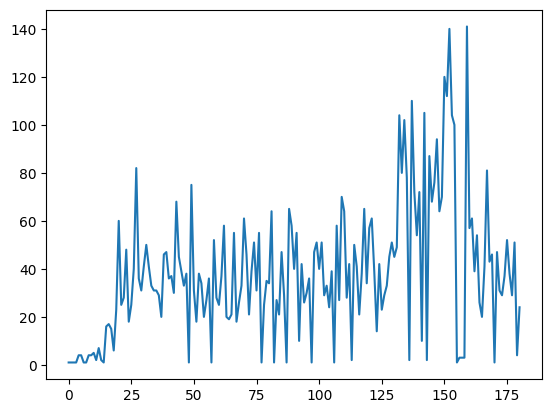

In [6]:
plt.plot(df['record_count'])

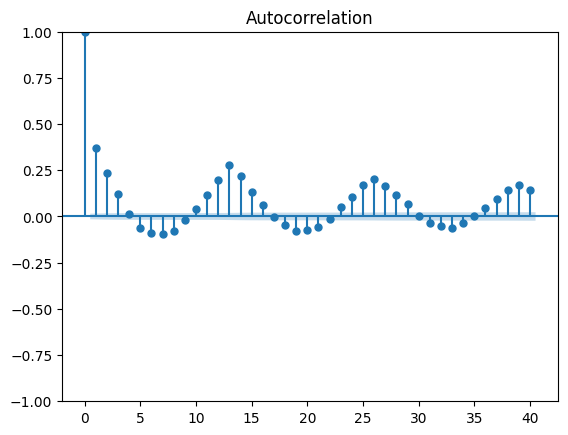

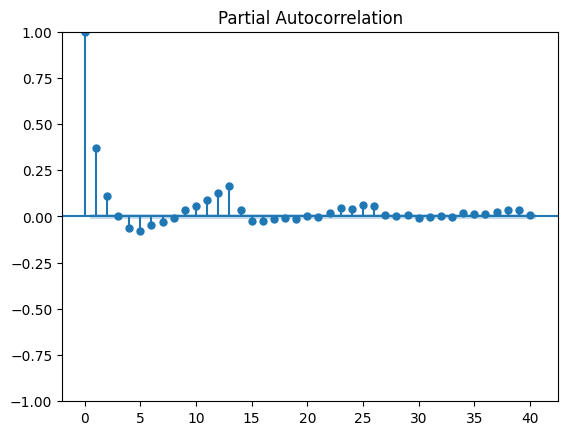

In [7]:
import pandas as pd
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Convert 'pickup_date' to a numerical representation suitable for Box-Cox
# Here, we'll use the timestamp (number of seconds since the Unix epoch)
# Convert datetime.date to datetime objects if needed
merged_clean['pickup_date'] = pd.to_datetime(merged_clean['pickup_date'])
merged_clean['pickup_date_numeric'] = merged_clean['pickup_date'].astype('int64') // 10**9

# Shift data to be positive if it contains zeros or negative values
min_value = merged_clean['pickup_date_numeric'].min()
if min_value <= 0:
    merged_clean['pickup_date_numeric'] = merged_clean['pickup_date_numeric'] - min_value + 1  # Shift by min_value + 1 to make all values positive

# Apply Box-Cox transformation if variance is not stable
merged_clean['actual_pickup_boxcox'], lam = boxcox(merged_clean['pickup_date_numeric'].dropna())  # Apply transformation to the numerical representation
merged_clean['rolling_std_original'] = merged_clean['pickup_date_numeric'].rolling(window=30).std()
merged_clean['rolling_std_boxcox'] = merged_clean['actual_pickup_boxcox'].rolling(window=30).std()

# Plot ACF and PACF to determine optimal lags
# Use the numerical representation for plotting
plot_acf(merged_clean['pickup_date_numeric'].dropna(), lags=40)
plot_pacf(merged_clean['pickup_date_numeric'].dropna(), lags=40)
plt.show()

In [8]:
df['pickup_date'] = pd.to_datetime(df['pickup_date']).dt.date

        date  actual_pickup  scheduled_pickup
0 2023-11-01             16                15
1 2023-11-02              0                 1
2 2023-11-03              0                 0
3 2023-11-04              0                 1
4 2023-11-05              0                 0


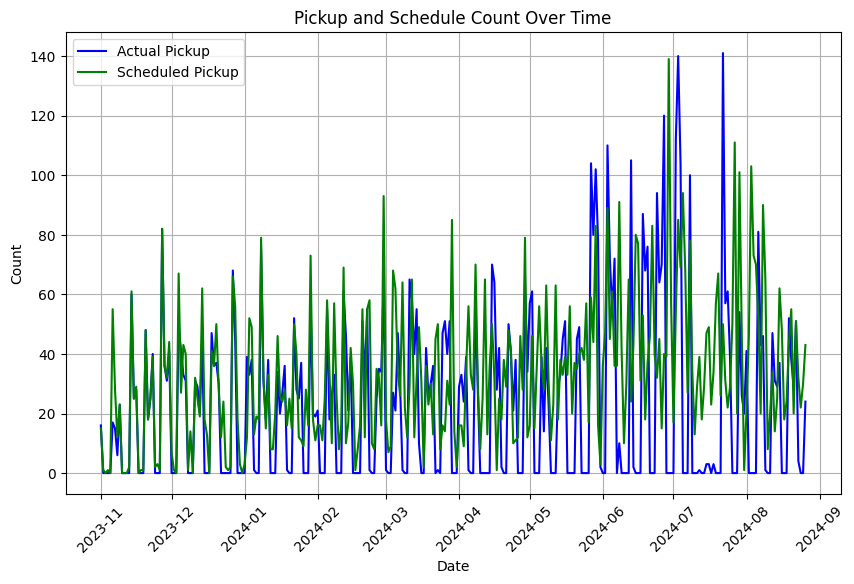

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Step 2: Convert 'pickup_date' and 'schedule_date' columns to datetime
merged_clean['pickup_date'] = pd.to_datetime(merged_clean['pickup_date'])
merged_clean['datetime_from'] = pd.to_datetime(merged_clean['datetime_from'])

# Step 3: Create time series based on the 'pickup_date' and 'schedule_date' columns
# Count the number of events for each date in both pickup_date and schedule_date
pickup_series = merged_clean.groupby(merged_clean['pickup_date'].dt.date).size().rename('actual_pickup')
schedule_series = merged_clean.groupby(merged_clean['datetime_from'].dt.date).size().rename('scheduled_pickup')

# Step 4: Define the time range for prediction
start_date = pd.to_datetime('2023-11-01')
end_date = pd.to_datetime('2024-08-26')
prediction_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Step 5: Reindex the time series to the full date range and fill missing values with 0
pickup_series = pickup_series.reindex(prediction_dates, fill_value=0)
schedule_series = schedule_series.reindex(prediction_dates, fill_value=0)

# Step 6: Combine the two series into one DataFrame, using the date as the index
merged_time_series = pd.DataFrame({
    'date': prediction_dates,
    'actual_pickup': pickup_series.values,
    'scheduled_pickup': schedule_series.values
})

# Display the merged time series
print(merged_time_series.head())

# Step 7: Plot the merged time series (optional)

# Plot Pickup Count and Schedule Count Over Time
plt.figure(figsize=(10, 6))
plt.plot(merged_time_series['date'], merged_time_series['actual_pickup'], label='Actual Pickup', color='blue')
plt.plot(merged_time_series['date'], merged_time_series['scheduled_pickup'], label='Scheduled Pickup', color='green')
plt.title('Pickup and Schedule Count Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [10]:
merged_clean.columns

Index(['datetime_from', 'pickup_date', 'pickup_location', 'quantity',
       'unique_client', 'unique id_x', 'address', 'age', 'dependents_qty',
       'sex_new', 'status', 'unique id_y', 'is_christmas', 'is_ramadan',
       'pickup_date_numeric', 'actual_pickup_boxcox', 'rolling_std_original',
       'rolling_std_boxcox'],
      dtype='object')

In [11]:
# Import packages
import yfinance as yf
import plotly.graph_objects as go

In [12]:
# Import packages
import plotly.express as px
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
from scipy.stats import boxcox

In [13]:

df['rolling_std_original'] = df['record_count'].rolling(window=30).std()
df['rolling_std_boxcox'] = merged_clean['actual_pickup_boxcox'].rolling(window=30).std()

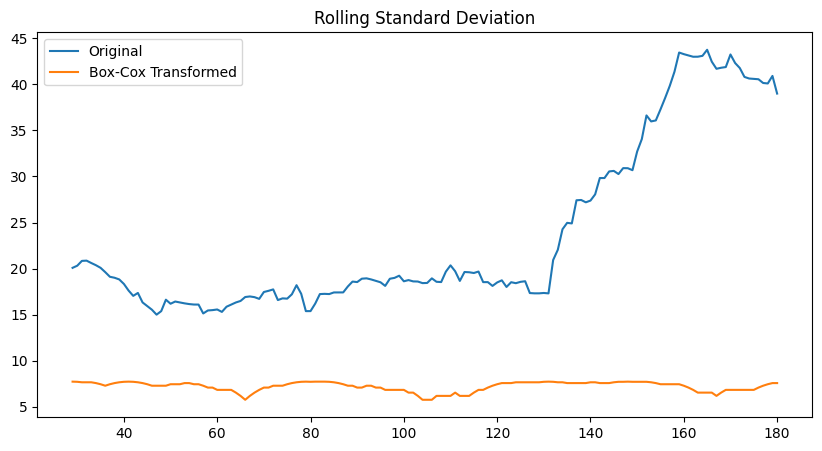

In [14]:
# Plot the rolling standard deviations
plt.figure(figsize=(10, 5))
plt.plot(df['rolling_std_original'], label='Original')
plt.plot(df['rolling_std_boxcox'], label='Box-Cox Transformed')
plt.legend()
plt.title('Rolling Standard Deviation')
plt.show()

In [18]:
# Merge df and merged_clean based on the 'pickup_date' column
merged_df = pd.concat([df, merged_clean], axis=0) # Pass dataframes as a list

# Print the merged DataFrame (optional)
merged_df.head()

,pickup_date,record_count,Demand_Lag7,Demand_Lag14,Demand_Lag30,rolling_std_original,rolling_std_boxcox,datetime_from,pickup_location,quantity,...,address,age,dependents_qty,sex_new,status,unique id_y,is_christmas,is_ramadan,pickup_date_numeric,actual_pickup_boxcox
0,2023-08-22,1.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-09-07,1.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-09-12,1.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-09-13,1.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-09-25,4.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
